## TODO-List

#### Open Questions
- [  ] t-SNE with test or train samples?

#### Training
- [✅] MLP 
- [  ] Different Models / Datasets

#### Visualization
- [  ] UMAP
- [  ] PCA
- [  ] **Live during training**

# Visualizing Embedding Evolution During Training

In this notebook, we train an MLP on MNIST and visualize how hidden representations (embeddings) evolve over training using t-SNE. This gives insight into how class structure emerges in the latent space over time.

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)  # Should print something like '11.8'
print(torch.backends.cudnn.version())  # Optional
print("CUDA available:", torch.cuda.is_available())

2.6.0+cu118
11.8
90100
CUDA available: True


In [4]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#train_subset, _ = torch.utils.data.random_split(train_data, [10000, len(train_data)-10000])
#train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [5]:
from torch.utils.data import Subset

# First, get all test labels
test_targets = test_data.targets.numpy()

# Define how many samples per class
samples_per_class = 100
num_classes = 10

# Collect indices (balanced subset)
selected_indices = []
for class_id in range(num_classes):
    class_indices = np.where(test_targets == class_id)[0]
    chosen = np.random.choice(class_indices, size=samples_per_class, replace=False)
    selected_indices.extend(chosen)

# Create a test subset DataLoader (shuffling not needed)
test_subset = Subset(test_data, selected_indices)
test_subset_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

In [6]:
print(len(train_data))
print(len(test_data))
print(len(test_subset))

60000
10000
1000


In [54]:
class MLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, return_embedding=False):
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        if return_embedding:
            return out, h
        return out

model_mlp = MLP().to(device)

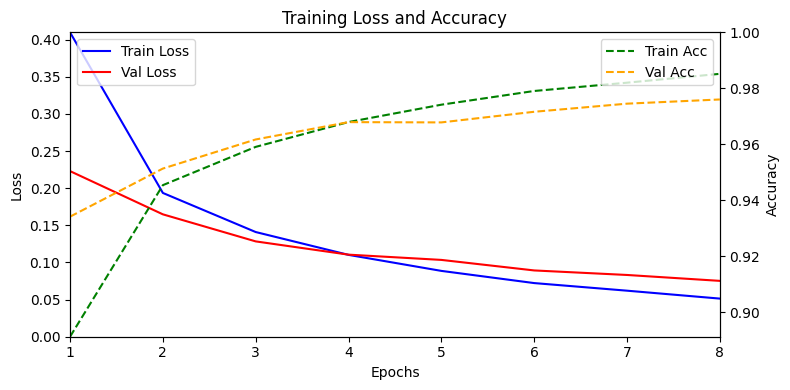

Epoch [1/8] | Train Loss: 0.4098, Acc: 0.8912 | Val Loss: 0.2230, Acc: 0.9341
Epoch [2/8] | Train Loss: 0.1936, Acc: 0.9454 | Val Loss: 0.1648, Acc: 0.9513
Epoch [3/8] | Train Loss: 0.1409, Acc: 0.9590 | Val Loss: 0.1283, Acc: 0.9617
Epoch [4/8] | Train Loss: 0.1102, Acc: 0.9679 | Val Loss: 0.1105, Acc: 0.9679
Epoch [5/8] | Train Loss: 0.0886, Acc: 0.9741 | Val Loss: 0.1034, Acc: 0.9678
Epoch [6/8] | Train Loss: 0.0722, Acc: 0.9790 | Val Loss: 0.0892, Acc: 0.9716
Epoch [7/8] | Train Loss: 0.0620, Acc: 0.9820 | Val Loss: 0.0831, Acc: 0.9745
Epoch [8/8] | Train Loss: 0.0513, Acc: 0.9852 | Val Loss: 0.0752, Acc: 0.9760
Recorded 376 embeddings in 8 epochs (47.00 per epoch).


In [55]:
from train_viz import train_model_with_embedding_tracking

results = train_model_with_embedding_tracking(
    model=model_mlp,
    train_loader=train_loader,
    test_loader=test_loader,
    test_subset_loader=test_subset_loader,
    device=device,
    epochs=8,
    learning_rate=0.001,
    embedding_mode='batch',
    batch_interval=10
)

##    return {
##        'train_losses': train_losses,
##        'val_losses': val_losses,
##        'train_accuracies': train_accuracies,
##        'val_accuracies': val_accuracies,
##        'test_subset_embeddings': test_subset_embeddings,
##        'test_subset_labels': test_subset_labels
##    }

# Video Animation
New

In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def visualize_embeddings_over_time(
    embeddings_list,
    labels,
    method='tsne',
    interpolate=False,
    steps_per_transition=10,
    frame_interval=50,
    cmap='Set2',
    figsize=(4, 4),
    dot_size=5,
    axis_lim=10,
    title_base='Embedding Evolution',
    pca_fit_basis='first',  # 'first', 'last', or 'all'
    max_frames=None
):
    assert method in ['tsne', 'pca'], "Currently supported: 'tsne', 'pca'"
    assert pca_fit_basis in ['first', 'last', 'all'], "pca_fit_basis must be 'first', 'last', or 'all'"

    projections = []

    if method == 'pca':
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)

        if pca_fit_basis == 'first':
            basis_data = embeddings_list[0]
        elif pca_fit_basis == 'last':
            basis_data = embeddings_list[-1]
        elif pca_fit_basis == 'all':
            basis_data = np.concatenate(embeddings_list, axis=0)

        pca.fit(basis_data)

        for i in range(1, len(embeddings_list)):
            if i > max_frames: break
            print(f"compute pca {i} ")
            projections.append(pca.transform(embeddings_list[i]))

    elif method == 'tsne':
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=2, init='pca', random_state=42)
        result = tsne.fit_transform(embeddings_list[0])
        projections.append(result)
        for i in range(1, len(embeddings_list)):
            if i > max_frames: break
            print(f"compute tsne {i} ")
            tsne = TSNE(n_components=2, init=projections[-1], random_state=42)
            result = tsne.fit_transform(embeddings_list[i])
            projections.append(result)

    # Interpolation
    if interpolate:
        projections_interp = []
        for a, b in zip(projections[:-1], projections[1:]):
            print(f"interpolation")
            for alpha in np.linspace(0, 1, steps_per_transition, endpoint=False):
                interp = (1 - alpha) * a + alpha * b
                projections_interp.append(interp)
        projections_interp.append(projections[-1])
    else:
        projections_interp = projections

    # Plot setup
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter([], [], s=dot_size, c=[], cmap=cmap, alpha=0.7)
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)
    #ax.set_xlabel(f'{method.upper()} Dimension 1')
    #ax.set_ylabel(f'{method.upper()} Dimension 2')
    #title = ax.set_title(f'{title_base} – Frame 0')

    def update(frame):
        scatter.set_offsets(projections_interp[frame])
        scatter.set_array(np.array(labels).flatten())
        #title.set_text(f'{title_base} – Frame {frame + 1}')
        return scatter,

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(projections_interp),
        interval=frame_interval,
        blit=True
    )

    return ani

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


compute pca 1 
compute pca 2 
compute pca 3 
compute pca 4 
compute pca 5 
compute pca 6 
compute pca 7 
compute pca 8 
compute pca 9 
compute pca 10 


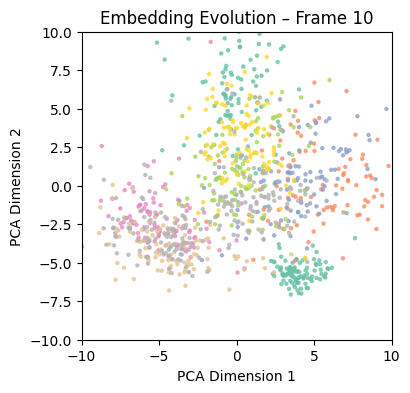

In [70]:
ani_pca = visualize_embeddings_over_time(
    embeddings_list=results["test_subset_embeddings"],
    labels=results["test_subset_labels"],
    method='pca',
    pca_fit_basis='all',   # or 'last', or 'all'
    max_frames=10
)
from IPython.display import HTML
HTML(ani_pca.to_jshtml())

compute tsne 1 
compute tsne 2 
compute tsne 3 
compute tsne 4 
compute tsne 5 
compute tsne 6 
compute tsne 7 
compute tsne 8 
compute tsne 9 
compute tsne 10 
compute tsne 11 
compute tsne 12 
compute tsne 13 
compute tsne 14 
compute tsne 15 
compute tsne 16 
compute tsne 17 
compute tsne 18 
compute tsne 19 
compute tsne 20 


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation
interpolation


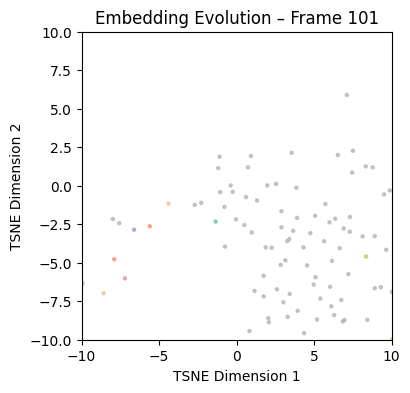

In [71]:
ani_tsne = visualize_embeddings_over_time(
    embeddings_list=results["test_subset_embeddings"],
    labels=results["test_subset_labels"],
    method='tsne',
    interpolate=True,
    steps_per_transition=5,
    max_frames=20
)
from IPython.display import HTML
HTML(ani_tsne.to_jshtml())

In [ ]:
# === Save as MP4 (with ffmpeg) ===
model_name = model._get_name()
lr = learning_rate
base_name = f"tsne_{model_name}_e{epochs}_lr{lr:.0e}"
i = 1
while os.path.exists(f"{base_name}_{i:03}.mp4"):
    i += 1
filename = f"{base_name}_{i:03}.mp4"

ani.save(filename, writer='ffmpeg', dpi=150)
print(f"Saved animation as {filename}")

# tSNE Computation

In [ ]:
# Labels should be the same everywhere
print(labels[0])
print(labels[1])

In [ ]:
embeddings[0]

In [ ]:
# Final epoch's data
final_embeddings = embeddings[-1]
final_labels = labels[-1]

# Convert to NumPy arrays (if not already)
final_embeddings = np.array(final_embeddings)
final_labels = np.array(final_labels)

# How many samples per class
samples_per_class = 200
num_classes = 10

# Collect indices
selected_indices = []
for class_id in range(num_classes):
    class_indices = np.where(final_labels == class_id)[0]
    chosen = np.random.choice(class_indices, size=samples_per_class, replace=False)
    selected_indices.extend(chosen)

# Subsample embeddings and labels
sampled_embeddings = final_embeddings[selected_indices]
sampled_labels = final_labels[selected_indices]

In [ ]:
# Optional: Refresh tSNE
epoch = 10

# Final epoch's data
final_embeddings = embeddings[epoch]
final_labels = labels[epoch]

# Subsample embeddings and labels
sampled_embeddings = final_embeddings[selected_indices]
sampled_labels = final_labels[selected_indices]

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(sampled_embeddings)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sampled_labels, cmap='tab10', alpha=0.8)
plt.title('t-SNE of Final Epoch Embeddings (Balanced Sample)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Digit Label')
plt.show()

# Animation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE

# === Compute t-SNE per epoch using selected_indices ===
tsne_results = []

# Epoch 0: PCA init
tsne = TSNE(n_components=2, init='pca', random_state=42)
result = tsne.fit_transform(embeddings[0][selected_indices])
tsne_results.append(result)

# Epochs 1+: use previous output for init
for epoch in range(1, len(embeddings)):
    tsne = TSNE(n_components=2, init=tsne_results[-1], random_state=42)
    result = tsne.fit_transform(embeddings[epoch][selected_indices])
    tsne_results.append(result)

# === Animation Setup ===
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter([], [], c=[], cmap='tab10', alpha=0.7)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('t-SNE Embedding Evolution')

# Use sampled_labels once — they're fixed
def update(frame):
    scatter.set_offsets(tsne_results[frame])
    scatter.set_array(sampled_labels)
    ax.set_title(f't-SNE Embedding – Epoch {frame + 1}')
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=len(tsne_results), interval=1000, blit=True)
#plt.show()

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Static figure (inline mode is fine)
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the initial frame (epoch 0)
sc = ax.scatter(
    tsne_results[0][:, 0], tsne_results[0][:, 1],
    c=sampled_labels, cmap='tab10', alpha=0.7
)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
title = ax.set_title("t-SNE Embedding – Epoch 1")

# Update function for slider
def update_epoch(epoch):
    print(epoch)
    sc.set_offsets(tsne_results[epoch])
    title.set_text(f't-SNE Embedding – Epoch {epoch + 1}')
    fig.canvas.draw_idle()

# IntSlider widget
epoch_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(tsne_results) - 1,
    step=1,
    description='Epoch:',
    continuous_update=True
)

# Connect slider to update function
widgets.interact(update_epoch, epoch=epoch_slider)

In [ ]:
import os

# === Define experiment info ===
model_name = model._get_name()
# Build a base name with settings
base_name = f"tsne_{model_name}_e{epochs}_lr{learning_rate:.0e}"  # e.g., tsne_MLP_e10_lr1e-03

# Auto-increment file index
i = 1
while os.path.exists(f"{base_name}_{i:03}.gif"):
    i += 1
filename = f"{base_name}_{i:03}.gif"

# Save the animation
ani.save(filename, writer='pillow')
print(f"Saved animation as {filename}")

# Video Animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE
import os

# === Interpolation between t-SNE results ===
def interpolate_tsne(embeddings_list, steps=10):
    interpolated = []
    for a, b in zip(embeddings_list[:-1], embeddings_list[1:]):
        for alpha in np.linspace(0, 1, steps, endpoint=False):
            interp = (1 - alpha) * a + alpha * b
            interpolated.append(interp)
    interpolated.append(embeddings_list[-1])  # include final frame
    return interpolated

# === Compute t-SNE per epoch using selected_indices ===
tsne_results = []

# Epoch 0
tsne = TSNE(n_components=2, init='pca', random_state=42)
result = tsne.fit_transform(embeddings[0][selected_indices])
tsne_results.append(result)

# Subsequent epochs
for epoch in range(1, len(embeddings)):
    tsne = TSNE(n_components=2, init=tsne_results[-1], random_state=42)
    result = tsne.fit_transform(embeddings[epoch][selected_indices])
    tsne_results.append(result)

# === Interpolate between epochs ===
tsne_results_interp = interpolate_tsne(tsne_results, steps=5)

# === Animation setup ===
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter([], [], cmap='tab10', alpha=0.7)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
title = ax.set_title('t-SNE Embedding Evolution')

def update(frame):
    scatter.set_offsets(tsne_results_interp[frame])
    scatter.set_array(sampled_labels)
    title.set_text(f't-SNE Embedding Evolution – Frame {frame + 1}')
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=len(tsne_results_interp), interval=100, blit=True)

In [ ]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
# === Save as MP4 (with ffmpeg) ===
model_name = model._get_name()
lr = learning_rate
base_name = f"tsne_{model_name}_e{epochs}_lr{lr:.0e}"
i = 1
while os.path.exists(f"{base_name}_{i:03}.mp4"):
    i += 1
filename = f"{base_name}_{i:03}.mp4"

ani.save(filename, writer='ffmpeg', dpi=150)
print(f"Saved animation as {filename}")